In [1]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as ss
import seaborn as sns
from cmocean import cm as cmo
%matplotlib inline

sns.set_style("whitegrid")

In [2]:
ds = xr.open_dataset("ERA5_1979-2020_SWVL.nc", chunks={'time':100}).sel(expver=1)
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 505)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    expver     int32 1
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-01-01
Data variables:
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
    swvl2      (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
    swvl3      (time, latitude, longitude) float32 dask.array<chunksize=(100, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-02 21:48:46 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [15]:
rootzone_swvl = (ds.swvl1)*70 + (ds.swvl2)*210 + (ds.swvl3)*720
rootzone_swvl.attrs['units'] = "kg m**-3"
rootzone_swvl.attrs['long_name'] = "Root zone soil moisture"

In [13]:
rootzone_swvl

<xarray.DataArray (time: 505, latitude: 721, longitude: 1440)>
dask.array<add, shape=(505, 721, 1440), dtype=float32, chunksize=(100, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    expver     int32 1
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-01-01
Attributes:
    units:      kg m**-3
    long_name:  Root zone soil moisture

In [22]:
def grid_climatology(data,mn=None,mx=None,lvn=10,limits=False,cmap=cmo.thermal,hide_ocean=False,save=False,savetype='pdf'):
    lat = data.latitude
    lon = data.longitude

    fig,axes = plt.subplots(nrows=4, ncols=3,figsize=(14,10),dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})
    axs=axes.flatten()
    for i in np.arange(0,12):
        avg = data.sel({'time': data['time.month']==i+1}).mean('time') 
        im = axes.flat[i].contourf(lon, lat, avg, levels=np.linspace(mn,mx,lvn+1),cmap=cmap,extend='both')
        axs[i].xaxis.set_visible(False)
        axs[i].yaxis.set_visible(False)
        axs[i].coastlines()
        axs[i].set_title('Month: '+ str(i+1),fontsize=15)
        if(hide_ocean):
            axs[i].add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
    
    fig.colorbar(im, ax=axes.ravel().tolist(),cax=fig.add_axes([0.92,0.1,.03,.8]))
    plt.subplots_adjust()
    plt.suptitle('ERA 5: {}, Units:{}'.format(data.attrs['long_name'], data.attrs['units']), fontsize=18)
    if(save):
        plt.savefig('figs/gr_' + data.attrs['long_name'] +
                    '_monthly.' + str(savetype))
    plt.show()

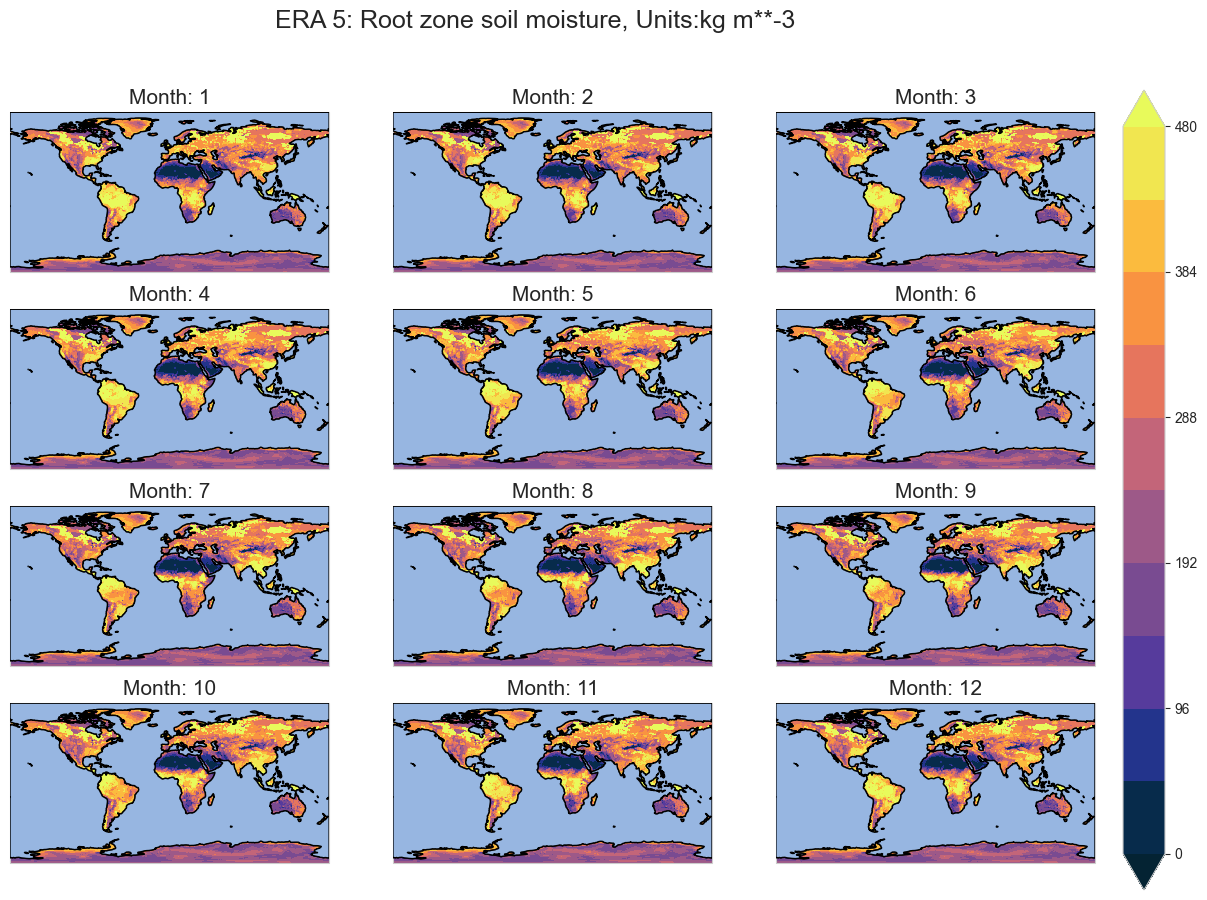

In [23]:
grid_climatology(rootzone_swvl, 0, 480, limits=True, hide_ocean=True, save=True)

In [7]:
def plot_climatology(x, show_ocean=True, limits=False, lmin=None, lmax=None, cmap=cmo.thermal, pre_title=""):
    avg = x.mean('time')
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    
    if(limits):
        avg.plot(ax=ax, vmin=lmin, vmax=lmax, cbar_kwargs={'shrink':0.5}, cmap=cmap, levels=np.linspace(lmin,lmax,11))
    else:
        avg.plot(ax=ax, vmin=lmin, vmax=lmax, cbar_kwargs={'shrink':0.5}, cmap=cmap)
    
    if show_ocean == False:
        ax.add_feature(cfeature.OCEAN, zorder=100, color='w')
        
    plt.title("{} Climatology of {}, Units: {}".format(pre_title, x.attrs['long_name'], x.attrs['units']))

In [24]:
def jja(month):
    return (month >= 6) & (month <= 8)

def djf(month):
    return (month == 12) | (month <= 2)

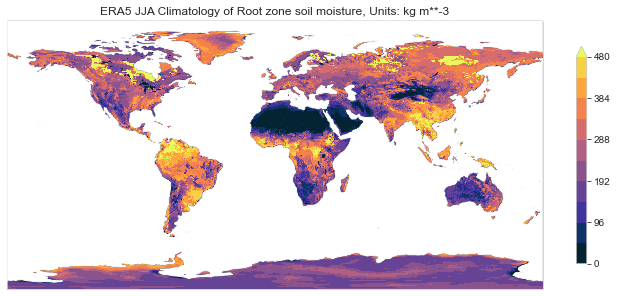

In [27]:
plot_climatology(rootzone_swvl.sel(time=jja(rootzone_swvl['time.month'])), show_ocean=False, limits=True, lmin=0, lmax=480, pre_title="ERA5 JJA")

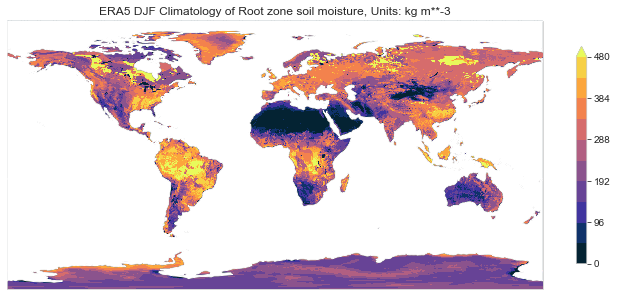

In [28]:
plot_climatology(rootzone_swvl.sel(time=djf(rootzone_swvl['time.month'])), show_ocean=False, limits=True, lmin=0, lmax=480, pre_title="ERA5 DJF")

In [32]:
def remove_time_mean(x):
    return(x - x.mean(dim='time'))

def remove_seasonality(x):
#     return((x-x.groupby('time.month').mean()).drop('month'))
    return x.groupby('time.month').map(remove_time_mean)

In [29]:
def plot_variance(x, show_ocean=True, lmin=None, lmax=None, limits=False, pre_title=""):
    x_without_seasonality = remove_seasonality(x)
    var = x_without_seasonality.var('time')

    fig = plt.figure(figsize=(12,8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    
    if(limits):
        var.plot(ax=ax, vmin=lmin, vmax=lmax, cbar_kwargs={'shrink':0.5}, cmap=cmo.thermal, levels=np.linspace(lmin,lmax,11))
    else:
        var.plot(ax=ax, vmin=lmin, vmax=lmax, cbar_kwargs={'shrink':0.5}, cmap=cmo.thermal)
    
    if show_ocean == False:
        ax.add_feature(cfeature.OCEAN, zorder=100, color='w')
        
    plt.title("{} Variance of {}, Units: ({})^2".format(pre_title, x.attrs['long_name'], x.attrs['units']))

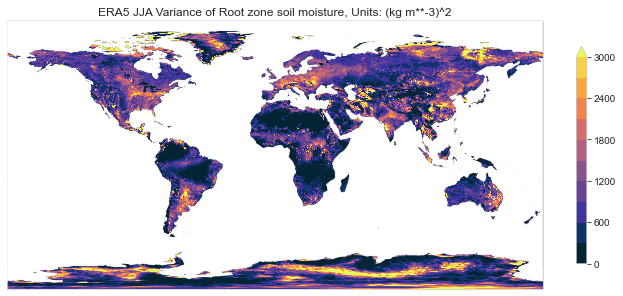

In [36]:
plot_variance(rootzone_swvl.sel(time=jja(rootzone_swvl['time.month'])), show_ocean=False, limits=True, lmin=0, lmax=3000, pre_title="ERA5 JJA")

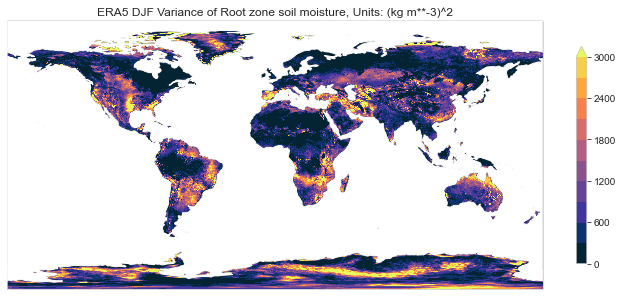

In [35]:
plot_variance(rootzone_swvl.sel(time=djf(rootzone_swvl['time.month'])), show_ocean=False, limits=True, lmin=0, lmax=3000, pre_title="ERA5 DJF")

In [37]:
def plot_skewness(x, show_ocean=True,season='',mx=None,mn=None,lvn=10,limits=False):
    x_without_seasonality = remove_seasonality(x)
    
    skew = ss.skew(x_without_seasonality, axis=0, nan_policy='omit')
    lat = x.latitude
    lon = x.longitude

    plt.figure(figsize=(12,8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    if(limits):
        plt.contourf(lon,lat,skew,levels=np.linspace(mn,mx,lvn),cmap='coolwarm',extend='both')
    else:
        plt.contourf(lon, lat, skew, cmap='coolwarm')
        
    plt.colorbar(shrink=0.5)
    ax.coastlines()
    
    if show_ocean == False:
        ax.add_feature(cfeature.OCEAN, zorder=100, color='w')

    plt.title(season + " Skewness of {}".format(x.attrs['long_name']))
    plt.show()

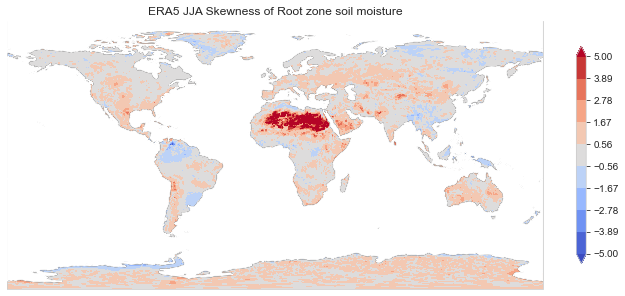

In [39]:
plot_skewness(rootzone_swvl.sel(time=jja(rootzone_swvl['time.month'])), show_ocean=False, limits=True, mn=-5, mx=5, season="ERA5 JJA")

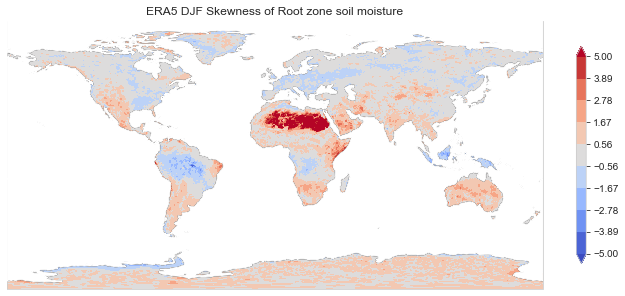

In [40]:
plot_skewness(rootzone_swvl.sel(time=djf(rootzone_swvl['time.month'])), show_ocean=False, limits=True, mn=-5, mx=5, season="ERA5 DJF")